<a href="https://www.kaggle.com/code/andreidolzhikov/baseline-v1?scriptVersionId=113177299" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing # библиотека для проведения нормализации

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# устанавливаем библиотеку
!pip install nltk

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [68]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [69]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [70]:

# Подгрузим наши данные из соревнования

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # самбмишн

# DATA_DIR = 'data'
# df_train = pd.read_csv('data/hotels_train.csv') # датасет для обучения
# df_test = pd.read_csv('data/hotels_test.csv') # датасет для предсказания
# sample_submission = pd.read_csv('data/submission.csv') # самбмишн


In [71]:

# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями

# sample data для трейна
df_train = df_train.sample(frac = 0.1, replace = False, random_state=42)

# такое название пока для того, чтобы не переписывать переменные в дальнейшем коде
sample_data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51574 entries, 488440 to 273809
Columns: 3890 entries, is_bad_review to nights_in_hotel
dtypes: float32(5), float64(3850), int64(35)
memory usage: 1.5 GB


## <center> Анализ текста отзывов

Данный раздел сделан в основном по рекомендациям Сергея Добдина.

### <center> [Sample](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html) данные

Насколько я понял, данный код, позволяет выбрать из тренировочного датасета, определенное количество рандомных строк, чтобы обучать модель на них, тем самым не нагружая компьютер большим количеством информации.

In [73]:
# sample_data = data.sample(frac = 0.1, replace = False, random_state=42)
# print(f'Далее рассматриваем датасет, с количеством строк: {sample_data.shape[0]}')

### <center> Работа с отзывами

Объединить положительные и отрицательные отзывы. Дальнейшую работу производим с данным признаком.

In [74]:

# объединяем положительные и отрицательные отзывы
sample_data['review'] = sample_data['negative_review'] + sample_data['positive_review']

# создаём метку для плохого отзыва (1 - True, 0 - False)
sample_data["is_bad_review"] = sample_data["reviewer_score"].apply(lambda x: 1 if x < 5 else 0)

# выбираем только релевантные столбцы для работы над отзывами
reviews_df = sample_data[["review", "is_bad_review", "reviewer_score", "sample"]]
reviews_df.head()


,review,is_bad_review,reviewer_score,sample
0,Would have appreciated a shop in the hotel th...,1,0.0,0
1,No tissue paper box was present at the roomNo...,1,0.0,0
2,Pillows Nice welcoming and service,1,0.0,0
3,No Negative Everything including the nice upgr...,1,0.0,0
4,No Negative Lovely hotel v welcoming staff,1,0.0,0


### <center> Очистка данных

In [75]:
# удалим 'No Negative' или 'No Positive' из текста
reviews_df["review"] = reviews_df["review"].apply(lambda x: x.replace("No Negative", "").replace("No Positive", ""))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [76]:
# https://webdevblog.ru/podhody-lemmatizacii-s-primerami-v-python/
# использование wordnet для анализа частей речи

import nltk
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer


def clean_text(text):
    # приводим к нижнему регистру
    text = text.lower()
    # разделение текста на слова и удаление знаков препинания 
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # удаляем цифры из текста
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # удаляем стоп-слова
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # удаляем пустые токены
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # лемматизация текста
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # удаляем слова из одной буквы
    text = [t for t in text if len(t) > 1]
    # объединяем текст
    text = " ".join(text)
    return(text)

# очистка текстовых данных
reviews_df["review_clean"] = reviews_df["review"].apply(lambda x: clean_text(x))

[nltk_data] Error loading averaged_perceptron_tagger: <urlopen error
[nltk_data]     [Errno -3] Temporary failure in name resolution>
[nltk_data] Error loading wordnet: <urlopen error [Errno -3] Temporary
[nltk_data]     failure in name resolution>
[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### <center> Создание новых признаков

In [77]:
# https://habr.com/ru/company/Voximplant/blog/446738/
# анализ тональности (настроения) текста отзыва

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

[nltk_data] Error loading vader_lexicon: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [78]:
# создадим признак кол-во символов в отзыве
reviews_df["nb_chars"] = reviews_df["review"].apply(lambda x: len(x))

# создадим признак кол-во слов в отзыве
reviews_df["nb_words"] = reviews_df["review"].apply(lambda x: len(x.split(" ")))

In [79]:
# https://habr.com/ru/post/585838/
# векторизация слов с помощью doc2vec и создание нового признака

from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# получим список из taggedDocument, которые являются кортежами из
# списка слов в отзыве и тега, соответсвующего порядковому номеру отзыва
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# обучение модели Doc2Vec с помощью текстовых данных
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# преобразуем каждый документ в вектор данных
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [80]:
# создание признака tf-idfs (оценка важности слова в тексте)
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

In [81]:
reviews_df.head()

,review,is_bad_review,reviewer_score,sample,review_clean,neg,neu,pos,compound,nb_chars,...,word_yuk,word_yum,word_yummy,word_zara,word_zero,word_ziggo,word_zip,word_zone,word_zoo,word_zuid
0,Would have appreciated a shop in the hotel th...,1,0.0,0,would appreciate shop hotel sell drinking wate...,0.049,0.617,0.334,0.9924,599,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,No tissue paper box was present at the room,1,0.0,0,tissue paper box present room,0.216,0.784,0.000,-0.2960,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Pillows Nice welcoming and service,1,0.0,0,pillow nice welcome service,0.000,0.345,0.655,0.6908,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Everything including the nice upgrade The Hot...,1,0.0,0,everything include nice upgrade hotel revamp s...,0.000,0.621,0.379,0.9153,155,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Lovely hotel v welcoming staff,1,0.0,0,lovely hotel welcome staff,0.000,0.230,0.770,0.7717,32,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [82]:
reviews_df.shape

(167615, 6822)

### <center> Исследовательский анализ данных

In [83]:
reviews_df["is_bad_review"].value_counts(normalize = True)

1    0.778946
0    0.221054
Name: is_bad_review, dtype: float64

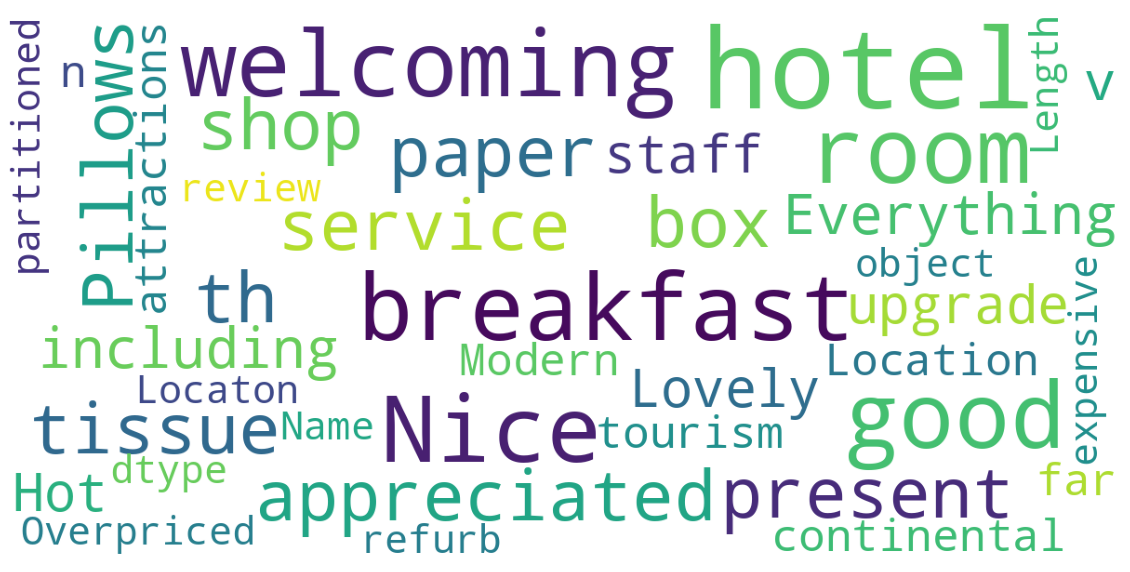

In [84]:
# использование wordcloud функции

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(reviews_df["review"])

In [ ]:
# Топ позитивных отзывов (содержит > 5 слов)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("pos", ascending = False)[["review", "pos"]].head(10)

In [ ]:
# Топ негативных отзывов (содержит > 5 слов)
reviews_df[reviews_df["nb_words"] >= 5].sort_values("neg", ascending = False)[["review", "neg"]].head(10)

## <center> Создание новых признаков из оставшихся признаков

#### Из признака `hotel_address`

Из признака `hotel_address` получаем признак города

In [ ]:
hotels_info = pd.DataFrame()
# функция выделения из адреса города
def adress_analysis(text):
    if text.split()[-1] == 'Kingdom':
        city = text.split()[-5]
        country = ' '.join(text.split()[-2:])
    else:
        city = text.split()[-2]
        country = text.split()[-1]
    return city

# создаем признак города
hotels_info['city'] = sample_data['hotel_address'].apply(adress_analysis)

In [ ]:
hotels_info['city']

Кодируем признак города

In [ ]:

import category_encoders as ce # импорт для работы с кодировщиком
encoder = ce.OneHotEncoder(cols=['city']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_info['city'])
hotels_info = pd.concat([hotels_info, type_bin], axis=1)

# удаляем исходный признак города
hotels_info = hotels_info.drop(columns=['city'])

In [ ]:
hotels_info.head(2)

#### Из признака `reviewer_nationality`

Кодируем признак национальности ревьюэра оставившего отзыв

In [ ]:

# убираем лишние пробелы из элементов признака
hotels_info['reviewer_nationality'] = sample_data['reviewer_nationality'].apply(lambda x: x.strip().lower())

# создаем список из 10 наиболее часто встречающихся национальностей
most_common_nations = hotels_info['reviewer_nationality'].value_counts(normalize=True)[:10].index.tolist()

# оставляем только национальности из списка, остальные Other
hotels_info['reviewer_nationality'] = hotels_info['reviewer_nationality'].apply(lambda x: x if x in most_common_nations else 'other')

# применяем однократное кодирование для признака (11 признаков)
import category_encoders as ce # импорт для работы с кодировщиком

encoder = ce.OneHotEncoder(cols=['reviewer_nationality']) # указываем столбец для кодирования
type_bin = encoder.fit_transform(hotels_info['reviewer_nationality'])
hotels_info = pd.concat([hotels_info, type_bin], axis=1)

# удаляем признак национальности
hotels_info = hotels_info.drop(columns=['reviewer_nationality'])


In [ ]:
hotels_info.head(2)

#### Из признака `tags`

In [ ]:
# функция перевода текста тегов в список
def tags_to_list(text):
    tag_list = text[2:-2].split('\', \'')
    tag_list = [i.strip().lower() for i in tag_list]
    return tag_list

hotels_info['tags'] = sample_data['tags'].apply(tags_to_list)

In [ ]:
hotels_info['tags'].head(2)

Работа с наиболее часто встречающимися тегами

In [ ]:
# создаём пустой список тегов
tags = []
# каждый новый встречающийся тег из каждой строки признака тегов добавляем в список
for tag_list in hotels_info['tags']:
    for tag in tag_list:
        tags.append(tag)
        
from collections import Counter
cnt = Counter(tags)

# Для тегов, встречающихся более 2000 раз, создаем отдельные признаки в новом датасете.
# Так же учитываем, что не рассматриваем теги, с количеством ночей. Из этих тегов получим количество ночей.
for i in cnt.most_common():
    if i[1] > 2000 and 'night' not in i[0]:
        feature = i[0]
        hotels_info[feature] = sample_data['tags'].apply(lambda x: 1 if feature in x else 0)

In [ ]:
hotels_info.head(2)

In [ ]:
hotels_info.info()

Работа с тегами, содержащими подстроку `night`

In [ ]:
def nights_in_hotel(tags_list):
    """
    Находит в списке тегов тег с количеством ночей.
    Из данного тега возвращается количество ночей.
    """
    for tag in tags_list:
        if 'night' in tag:
            for i in tag.split():
                if i.isdigit():
                    return i
    return np.NaN

# применяем функцию, получаем признак в строковом формате, внутри которого число (присутствуют пропуски)
hotels_info['nights_in_hotel'] = hotels_info['tags'].apply(nights_in_hotel)

# заполняем пропуски модой
hotels_info['nights_in_hotel'] = hotels_info['nights_in_hotel'].fillna(hotels_info['nights_in_hotel'].mode()[0])

# приводим к типу int
hotels_info['nights_in_hotel'] = hotels_info['nights_in_hotel'].astype('int')


In [ ]:
hotels_info['nights_in_hotel'].head()

## <center> Преобразование признаков

Пока пропустим этот шаг.

### Нормализация. RobustScaler

Нормализировать осталось один признак `nights_in_hotel`.

In [ ]:
# norm_cols_df = hotels_info[['nights_in_hotel']]

In [ ]:
# # Копируем названия столбцов, которые теряются при использовании fit_transform()
# col_names = list(norm_cols_df.columns)

# # инициализируем нормализатор RobustScaler
# r_scaler = preprocessing.RobustScaler()

# # копируем исходный датасет
# df_r = r_scaler.fit_transform(norm_cols_df)

# df_r = pd.DataFrame(df_r, columns=col_names)

In [ ]:

# # к датасету добавляем столбец с нормализированным признаком количества ночей
# hotels_info = pd.concat([hotels_info, df_r], axis=1)

## <center> Соединения датасета с отзывами и датасета с информацией об отеле

In [ ]:
data = pd.concat([reviews_df, hotels_info], axis=1)

In [ ]:
data.shape

## <center> Продолжение расчета

In [ ]:
# data.nunique(dropna=False)

In [ ]:
# plt.rcParams['figure.figsize'] = (15,10)
# sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

In [ ]:
# убираем признаки которые еще не успели обработать, 
# модель на признаках с dtypes "object" обучаться не будет, просто выберим их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

In [ ]:
data.info()

In [ ]:
# Теперь выделим тестовую часть
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [ ]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [ ]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

In [ ]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [ ]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [ ]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

In [ ]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических. 
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

In [ ]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [ ]:
test_data.sample(10)

In [ ]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [ ]:
test_data.shape

In [ ]:
sample_submission

In [ ]:
predict_submission = model.predict(test_data)

In [ ]:
predict_submission

In [ ]:
len(predict_submission)

In [ ]:
list(sample_submission)

In [ ]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)